# Quaternion Kalman Filters with JAXitude

This notebook walks through increasingly complex filtering algorithms for quaternion prediction and filtering using tools available via JAXitude and its submodules.
These quaternions will represent attitudes, which means each quaternion $\beta$ discussed here has, or should have, a length of one: $|\beta| = 1$. 
As a reminder, the first element of $\beta$ is the scalar component of the unit quaternion.

As always with JAXitude, quaternions $\beta$ will be represented by a column vector, not a row vector or 1D array!

```Python
b = jnp.array(
    [[b0],
     [b1],
     [b2],
     [b3]]
)
```

The same goes for attitude rate vectors $\omega$.

```Python
w = jnp.array(
    [[w0],
     [w1],
     [w2]]
)
```

## Loading Simulation Data

For these exercises, we'll make use of simulated attitude and attitude rates of a rigid body undergoing two episodes of angular acceration.

In [ ]:
from pathlib import Path
import sys
import os
sys.path.append(str(Path(os.getcwd()).parent))

from numpy import genfromtxt
import jax.numpy as jnp
from jax import config
config.update('jax_enable_x64', True)  # Default to double float precision.

data_path = Path('data/') / 'attitude_acc1'


# Load observed gyroscope data.
with open(data_path / 'gyro-0.csv', 'r') as f:
    w_obs_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true gyroscope data.
with open(data_path / 'ref_gyro.csv', 'r') as f:
    w_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true attitude data (parameterized with quaternions).
with open(data_path / 'ref_att_quat.csv', 'r') as f:
    b_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true attitude data (parameterized with Euler angles).
with open(data_path / 'ref_att_euler.csv', 'r') as f:
    ea_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# load simulation time data.
with open(data_path / 'time.csv', 'r') as f:
    t_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Remember: all vector data must be transformed to column vectors to utilize
# JAXitude calculations!  Also, convert deg/s to rad/s
n_steps = jnp.shape(t_data)[0]
w_obs_data = w_obs_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.
w_true_data = w_true_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.
b_true_data = b_true_data.reshape((n_steps, 4, 1))
ea_true_data = ea_true_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.

## Adding Noise to 'True' Quaternion Data

We now want to simulate quaternion measurements from the simulated quaternion time series.
To do so, we'll make use of `jaxitude.operations.error.QuatNoise`, `jax.random`, and `jax.vmap()`.

In [ ]:
from jax import vmap
from jax.random import PRNGKey, split

from jaxitude.operations.error import QuatNoise

# We need a random key to generate noise.
key = PRNGKey(1)

# Quaternion rotation angle error standard deviation will be set to 8 degrees.
sigma_dtheta = 8. * jnp.pi / 180.  # Convert to radians for JAXitude!


# For this helper function, we'll define it for a single key, b argument pair
# and then vectorize with vmap.
@vmap
def addnoise_sample(key: int, b: jnp.ndarray) -> jnp.ndarray:
    """ This helper function takes the quaternion set b, makes sure it is
        normalized, and adds noise.
    """
    # We get the rotation matrix R(b) by calling the instantiated Quaternion
    # object.  Note that we also normalized the quaternion set.
    return QuatNoise.addnoise(key, b / jnp.linalg.norm(b), sigma_dtheta)

# Simulate measured attitude time series.
key, subkey = split(key)
b_obs_data = addnoise_sample(split(subkey, n_steps),b_true_data)


## Measurement, Noise, and Dynamics Models

Before we start implementing any filters, let us first define some measurement models and a dynamical model for our system. 
We will have two sets of data at any given time step $k$: gyroscope rate vector measurements $\hat{\omega}$ and measured quaternions $\hat{\beta}$.
The Farrenkopf gyroscope measurement error model relating a measured attitude rate $\hat{\omega}$ to a true rate $\omega$ will be used:

$\hat{\omega} = \omega + \mathbf{b} + \eta_{\omega}$,

where $\mathbf{b}$ is the gyroscope bias at the time of measurement and $\eta_{\omega} \sim \mathcal{N}(0, [R_{\omega}])$ is the attitude rate uncorrelated measurment error vector with covariance $[R_{\omega}]$. 
The bias $\mathbf{b}$ is modeled a Gaussian random walk:

$\dot{\mathbf{b}} = \eta_{\mathbf{b}}$,

where $\eta_{\mathbf{b}} \sim \mathcal{N}(0, [R_{\mathbf{b}}])$ is the bias rate uncorrelated measurement error with covariance $[R_{\mathbf{b}}]$.

As we will find out later, defining the quaternion measurement model is more challenging. 
For now, we will assume a simple additive model akin to that used for $\hat{\omega}$:

$\hat{\beta} = \beta + \eta_{\beta}$,

where $\eta_{\beta} \sim \mathcal{N}(0, [R_{\beta}])$ is the bias rate uncorrelated measurement error with covariance $[R_{\beta}]$.
An astute mathematician might have already spotted a problem with this formulation --- namely, that the unit constraint $|\beta|=1$ results in a singular covariance matrix $[R_{\beta}]$! 

Let's instantiate the covariance matrices $[R_{\mathbf{b}}]$, $[R_{\omega}]$, and $[R_{\beta}]$.

In [ ]:
sigmaR_b = 1e-3
sigmaR_w = 1e-3
sigmaR_bias = 1e-3

R_b = jnp.eye(4) * sigmaR_b**2.
R_w = jnp.eye(3) * sigmaR_w**2.
R_bias = jnp.eye(3) * sigmaR_bias**2.


The full seven-dimensional state vector will be a combination of quaternion parameters and the gyroscope bias: 

$\mathbf{x} = \begin{bmatrix} \beta \\ \mathbf{b} \end{bmatrix}$

subject to the constraint $|\beta| = 1$. 
Similarly, we define the state noise vector $\eta$ as

$\mathbf{\eta} = \begin{bmatrix} \eta_{\omega_4} \\ \eta_{\mathbf{b}} \end{bmatrix}$.


The dynamical system will relate the true attitude rate $\omega$ to the quaternion rate using the following equation.

$\dot{\beta} = \frac{1}{2}\beta \otimes \omega_4 = \frac{1}{2}\beta \otimes (\hat{\omega}_4 - \mathbf{b}_4 - \eta_{\omega,4})$,

where $\omega_4 = [0, \omega]^T$, $\hat{\omega}_4 = [0, \hat{\omega}]^T$, $\mathbf{b}_4 = [0, \mathbf{b}]^T$, and $\eta_{\omega_4} = [0, \eta_{\omega}]^T$.
Quaternion multiplication is denoted with the $\otimes$ operator.
Combining $\dot{\beta}$ with the bias rate model $\hat{\mathbf{b}}$ yields our full dynamical model given the current rate measurements $\hat{\omega}$:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x} | \hat{\omega}_4) + \mathbf{g}(\mathbf{x}, \mathbf{\eta})$,

where

$\mathbf{f}(\mathbf{x} | \hat{\omega}_4) = \begin{bmatrix}\frac{1}{2}\beta \otimes (\hat{\omega}_4 - \mathbf{b}_4) \\ \mathbf{0} \end{bmatrix}$,

and

$\mathbf{g}(\mathbf{\eta}) = \begin{bmatrix}-\frac{1}{2}\beta \otimes \eta_{\omega_4} \\ \mathbf{\eta}_{\mathbf{b}} \end{bmatrix}$.

We also need to track the state estimate covariance $[P]$, which requires that we also quantify any uncertainty in the underlying dynamics model via a process covariance matrix $[Q]$. 
Estimating $[Q]$ is no trivial task, so it will just be provided. 

In [ ]:
from jax.scipy.linalg import block_diag

# This is a tuned approximation...  
sigmaQ_b = 1e-2
sigmaQ_bias = 1e-3

q_gain = 10.
Q = q_gain * block_diag(
    jnp.eye(4) * sigmaQ_b**2,
    jnp.eye(3) * sigmaQ_bias**2
)


For all filters presented in the notebook, we will predict state $\mathbf{x}_{k+1}$ from $\mathbf{x}_{k}$ by numerically solving $\dot{\mathbf{x}}$ along the time step $dt=t_{k+1} - t_k$. 
This numerical ODE solution will serve as the state transition equation.
Although we will use higher-order ODE integrators, an example of this state transition equation for $\mathbf{x}$ using Euler's method is:

$\mathbf{x}_{k + 1} = \mathbf{x}_{k} + \dot{\mathbf{x}}_kdt$.

The corresponding state covariance matrix $[P]_{k}$ will be predicted by numerically solving the the Ricatti differential equation for $[\dot{P}]$. 
To propogate a covariance matrix requires linearizing $\dot{\mathbf{x}}$ about the current state estimate $\delta\mathbf{x} = \mathbf{x} - \bar{\mathbf{x}}$:

$\delta\dot{\mathbf{x}} = [F]_{\bar{\mathbf{x}}}\delta\mathbf{x} + [G]_{\bar{\mathbf{x}},\eta=0}\eta$

where $[F]_{\bar{\mathbf{x}}}$ is the linearized dynamics matrix of $\mathbf{f}$ and $[G]_{\bar{\mathbf{x}},\eta=0}$ is the linearized noise model matrix of $\mathbf{g}$, both linearized around the current state vector estimate $\hat{\mathbf{x}}$.
The Ricatti equation for $[\dot{P}]$ can then be written as 

$[\dot{P}] = [F][P] + [P][F]^T + [G][\text{Diag}([R_{\omega}], [\mathbf{0}]_{3\times3})][G]^T + [Q]$.

## Algorithm One: Additive Extended Kalman Filter

Let us start with an Additive Extended Kalman Filter (AEKF), which defines the quaternion estimate as $\bar{\beta}=E(\beta)$ and the estimate error as $\Delta\beta=\beta - \bar{\beta}$. 
This setup is fairly conventional for filtering. 
Note that the AEKF formulation does not respect the unit constraint we've imposed on $\beta$:

$E(|\beta|^2) = E(|\hat{\beta} + \Delta\beta|^2) = |\beta|^2 + E(|\Delta\beta|^2) > 1$. 

For now, we'll ignore this potential pitful and start putting together the filter, first by making use of `jaxitude.operations.evolution.evolve_quat()` to construct functions $\mathbf{f}$ and $\mathbf{g}$.
Since we'll be building a few different filters, let's put these function definintions into a class, each as static methods.

In [ ]:
from jaxitude.operations.evolution import evolve_quat

class AEKF:
    @staticmethod
    def f(
        x: jnp.ndarray,
        w: jnp.ndarray,
    ) -> jnp.ndarray:
        """ Dynamical system equations relating current state and measured rates w
            to dx/dt.

        Args:
            x (jnp.ndarray): 7x1 matrix, state vector.
            w (jnp.ndarray): 3x1 matrix, measured rate vector.

        Returns:
            jnp.ndarray: 7x1 matrix, dx/dt.
        """
        return jnp.vstack(
            [
                evolve_quat(x[:4, :], w - x[4:, :]),
                jnp.zeros((3, 1))
            ]
        )


    @staticmethod
    def g(
        x: jnp.ndarray,
        eta: jnp.ndarray,
    ) -> jnp.ndarray:
        """ System noise equations calculated from current state and noise vector.

        Args:
            x (jnp.ndarray): 7x1 matrix, state vector.
            eta (jnp.ndarray): 7x1 matrix, noise vector.

        Returns:
            jnp.ndarray: 7x1 matrix, noise contribution to dx/dt.
        """
        return jnp.vstack(
            [
                evolve_quat(x[:4, :], eta[:4, :]),
                eta[4:, :]
            ]
    )

Next, we will use `jaxitude.operations.linearization.tangent()` to calculate the linearized differential equation matrices $[F]$ and $[G]$ at some arbitrary state estimate $\bar{\mathbf{x}}$.

In [ ]:
from jaxitude.operations.linearization import tangent


def tangent_f(
    x_ref: jnp.ndarray,
    w_obs: jnp.ndarray
) -> jnp.ndarray:
    """ Gets the linearized kinematics equation matrix at x=x_ref:
        F = Jac(f(x, w=w_obs))(x_ref).

    Args:
        x_ref (jnp.ndarray): 7x1 matrix, state vector estimate to linearize
            at.
        w_obs (jnp.ndarray): 3x1 matrix, measured attitude rate vector.

    Returns:
        jnp.ndarray: 7x7 matrix, linearized kinematics system matrix F.
    """
    # Linearize f(x, w=w_obs) about x_ref.
    return tangent(
        lambda x: AEKF.f(x, w_obs),
        7, 0, x_ref
    )


def tangent_g(
    x_ref: jnp.ndarray,
) -> jnp.ndarray:
    """ Gets the linearized kinematics equation matrix at eta=0:
        G = Jac(g(x=x_ref, eta))(eta=0).

    Args:
        x_ref (jnp.ndarray): 7x1 matrix, state vector to linearize at.

    Returns:
        jnp.ndarray: 7x7 matrix, linearized noise system matrix G.
    """
    # Linearize g(x=x_ref, eta) about eta=0.
    return tangent(
        lambda eta: AEKF.g(x_ref, eta),
        7, 0, jnp.zeros((7, 1))
    )

# Store new functions as static methods for safe keeping.
AEKF.tangent_f = staticmethod(tangent_f)
AEKF.tangent_g = staticmethod(tangent_g)

To calculate the state vector and state covariance transition functions, we need an ODE solver/integrator (these terms interchangeably in this context). 
Let us make use of `jaxitude.operations.integrator.autonomous_rk4()` to numerically integrate along the each time step $dt$. 
Also, we'll make use of `jaxitude.operations.evolution.evolve_P_ricatti()` to implement the $[P]$ matrix differential equation.

It is work reminding the reader of JAXitude's numerical ODE integrator API.
Each autonomous (time-independent) integrator, such as `autunomous_rk4()`, expects for its first argument a Python function `func`. 
This callable function's first argument be the (mathematical) function you are trying to solve for using the ODE integrator. 
In the first function below (`pred_x()`), we are trying to solve the state vector $\mathbf{x}$ using `AEKF.f()` (which is our `func` in this example), whose first argument is  `x_prior`, which indeed corresponds to the vector we are trying to solve.
Naturally, `autunomous_rk4()` expects as it's second argument the value of said vector during this integration time step. 
The ODE integration time step $dt$ must be `autunomous_rk4()`'s third argument, followed lastly by any other arguments to pass onto `func`.

In [ ]:
import importlib
from jaxitude.operations import evolution
importlib.reload(evolution)

from jaxitude.operations.evolution import evolve_P_ricatti
from jaxitude.operations.integrator import autonomous_rk4


# We can calculate dt directly from the data set really quick.
dt = t_data[1] - t_data[0]


def pred_x(
    x_prior: jnp.ndarray,
    w_obs: jnp.ndarray,
    dt: float
) -> jnp.ndarray:
    """ Predicts new state vector x_post from x_prior and w_obs along time
        interval dt.

    Args:
        x_prior (jnp.ndarray): 7x1 matrix, prior state vector estimate.
        w_obs (jnp.ndarray): 3x1 matrix, current attitude rate vector
            measurement
        dt (float): time step to integrate.

    Returns:
        jnp.ndarray: 7x1 matrix, state vector transition output along time step
            dt.
    """
    return autonomous_rk4(
        AEKF.f,
        x_prior,
        dt,
        w_obs
    )


def pred_P_ricatti(
    P_prior: jnp.ndarray,
    F_prior: jnp.ndarray,
    Q: jnp.ndarray,
    dt
) -> jnp.ndarray:
    """ Predict P_post from x_prior and covariance structures using Ricatti
        equation integrated with the RK4 method.

    Args:
        P_prior (jnp.ndarray): 7x7 matrix, prior P estimate.
        F_prior (jnp.ndarray): 7x7 matrix, linearized kinematics model
            evaluated at x_prior and w_obs.
        Q (jnp.ndarray): 6x6 matrix, process noise covariance.
        dt (float): Integration time interval.

    Returns:
        jnp.ndarray: Posterior P estimate from Ricatti equation integration.
    """
    return autonomous_rk4(
        evolve_P_ricatti,
        P_prior,
        dt,
        F_prior,
        Q
    )

# Again, add these functions to AEKF as static methods for safe keeping.
AEKF.pred_x = staticmethod(pred_x)
AEKF.pred_P_ricatti = staticmethod(pred_P_ricatti)

Now we can put the functions above together to calculate the Kalman matrix $[K]$ (see [Discrete-time Measurements](https://en.wikipedia.org/wiki/Extended_Kalman_filter) for more details), with which we can produce a new estimate from the predicted and observed state vectors.
First, we need to define a measurement matrix $[H]$ that maps the state vector $\mathbf{x}$ to observable quantities $\mathbf{z} = \hat{\beta}$:

$\hat{\beta} = [H]\mathbf{x} + \eta_{\beta}$.

Since we are directly estimating $\beta$ in this filter, the $[H]$ matrix should simply be a $4\times4$ identify matrix concatenated with a $4\times3$ zero matrix:

$[H] = [I_{4\times4}, 0_{4\times3}]$.

In [ ]:
from typing import Tuple

# Define the measurement matrix and add to AEKF class.
H = jnp.hstack([jnp.eye(4), jnp.zeros((4, 3))])
AEKF.H = H


def get_K(
    P_post: jnp.ndarray,
    R_b: jnp.ndarray,
    H: jnp.ndarray
) -> jnp.ndarray:
    """ Calculate the Kalman gain matrix K.

    Args:
        P_post (jnp.ndarray): 6x6 matrix, predicted state covariance.
        R_s (jnp.ndarray): 3x3 matrix, observed MRP s covariance.
        H (jnp.ndarray): 4x7 matrix, measurement model matrix.

    Returns:
        jnp.ndarray: 6x3 matrix, Kalman gain that also maps MRP s prediction
            error back to state space.
    """
    return P_post @ H.T @ jnp.linalg.inv(
        H @ P_post @ H.T + R_b
    )

# Add get_K() to AEKF as as static method.
AEKF.get_K = staticmethod(get_K)


def filter_step(
    x_prior: jnp.ndarray,
    P_prior: jnp.ndarray,
    w_obs: jnp.ndarray,
    b_obs: jnp.ndarray,
    R_w: jnp.ndarray,
    R_b: jnp.ndarray,
    Q: jnp.ndarray,
    H: jnp.ndarray,
    dt: float,
) -> Tuple[jnp.ndarray]:
    """ A single MRP EKF timestep

    Args:
        x_prior (jnp.ndarray): 7x1 matrix, prior state vector estimate.
        P_prior (jnp.ndarray): 7x7 matrix, prior state covariance estimate.
        w_obs (jnp.ndarray): 3x1 matrix, observed attitude rate vector.
        b_obs (jnp.ndarray): 4x1 matrix, observed attitude, represented with
            quaternion b.
        R_w (jnp.ndarray): 3x3 matrix, attitude vector w covariance.
        R_b (jnp.ndarray): 4x4 matrix, quaternion measurement covariance.
        Q (jnp.ndarray): 7x7 matrix, process noise covariance for attitude
            rates and gyroscopic bias.
        H (jnp.ndarray): 4x7 matrix, measurement model matrix.
        dt (float): Integration time interval.

    Returns:
        Tuple[jnp.ndarray]: 6x1 matrix, 6x1 matrix, 6x6 matrix, updated
            state vector, noise vector, and process covariance estimates.
    """
    # Get linearized kinematics and noise matrices.
    F_prior = AEKF.tangent_f(x_prior, w_obs)
    G_prior = AEKF.tangent_g(x_prior)

    # Get posterior predictions for state vector and state covariance
    # matrix.
    x_post = AEKF.pred_x(x_prior, w_obs, dt)
    P_post = AEKF.pred_P_ricatti(P_prior, F_prior, Q, dt)

    # Get posterior error and Kalman gain.
    y = b_obs - H @ x_post
    K = AEKF.get_K(P_post, R_b, H)

    # Update state vector and state covariance estimate with Kalman gain.
    x_new = x_post + K @ y
    P_new = (jnp.eye(7) - K @ H) @ P_post

    return x_new, P_new

# Add filter_step() to AEKF as as static method.
AEKF.filter_step = staticmethod(filter_step)

Before we actually test out this algorithm, it should be pointed out how useful modularizing functions in one's workflow can be. 
Each of these functions can be individually unit tested, which is great for maintenance. 
The function `filter_step()` is now far more readable than if we were to have shoved all the logic used in our building blocks into it.
Finally, JAX wants you to take such a functional approach, and it also let's your code look more 'mathy'. 
Note that dynamically adding state methods and variables, as has been done multiple times above, to a class definition is not necessarily 'functional', but for these worked examples, we will let it slide.

Now, let's see how this AEKF algorithm works. First we need to define the initial state vector and state covariance matrix.

In [ ]:
# The bias should be around three degrees for all gyroscope axes.
bias = jnp.full((3, 1), 3. * jnp.pi / 180.)

# The initial quaternion values will be the mean of the first five observations.
b0 = jnp.mean(b_obs_data[:5], axis=0)
x = jnp.vstack([b0, bias])

# The initial state covariance will be the process covariance matrix multiplied
# by a constant > 1.
P = 5. * Q.copy()

Now let us wrap `AEKF.filter_step()` into a jitted function to later call.

In [ ]:
from jax import jit
# from jax.lax import scan

# Always reset!
# The bias should be around three degrees for all gyroscope axes.
bias = jnp.full((3, 1), 3. * jnp.pi / 180.)

# The initial quaternion values will be the mean of the first five observations.
b0 = jnp.mean(b_obs_data[:5], axis=0)
x = jnp.vstack([b0, bias])

# The initial state covariance will be the process covariance matrix multiplied
# by a constant > 1.
P = 5. * Q.copy()


@jit
def step(
    x: jnp.ndarray,
    P: jnp.ndarray,
    w_obs: jnp.ndarray,
    b_obs: jnp.ndarray
) -> Tuple[jnp.ndarray]:
    """ AEKF filter step for given matrices R_w, R_b, and Q.
    """
    return AEKF.filter_step(
        x, P, w_obs, b_obs,  # Variables.
        R_w, R_b, Q, AEKF.H, dt  # Constants.
    )


# Loop through and append new estimates.
x_list = []
P_list = []
for i in range(n_steps):
    x_list.append(x)
    P_list.append(P)
    x, P = step(
        x, P,
        w_obs_data[i], b_obs_data[i],
    )

# Convert to arrays.
x_arr = jnp.array(x_list)
P_arr = jnp.array(P_list)

Let's get some plots up and running.

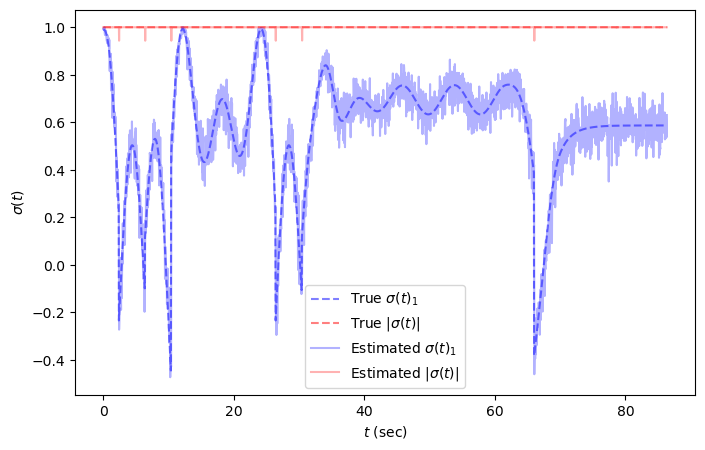

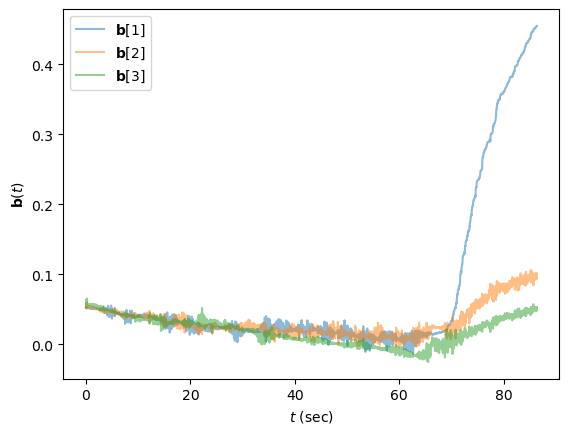

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(
    t_data[:], b_true_data[:, 0, 0], alpha=0.5, color='blue', ls='--',
    label=r'True $\sigma(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(b_true_data[:, :, 0], axis=1), alpha=0.5,
    color='red', label=r'True $|\sigma(t)|$', ls='--'
)
plt.plot(
    t_data[:], x_arr[:, 0, 0], alpha=0.3, color='blue', ls='-',
    label=r'Estimated $\sigma(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(x_arr[:, :4, 0], axis=1), alpha=0.3,
    color='red', label=r'Estimated $|\sigma(t)|$'
)
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\sigma(t)$')
plt.legend()
plt.show()

plt.plot(t_data[:], x_arr[:, 4, 0], alpha=0.5, label=r'$\mathbf{b}[1]$')
plt.plot(t_data[:], x_arr[:, 5, 0], alpha=0.5, label=r'$\mathbf{b}[2]$')
plt.plot(t_data[:], x_arr[:, 6, 0], alpha=0.5, label=r'$\mathbf{b}[3]$')
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\mathbf{b}(t)$')
plt.legend()
plt.show()

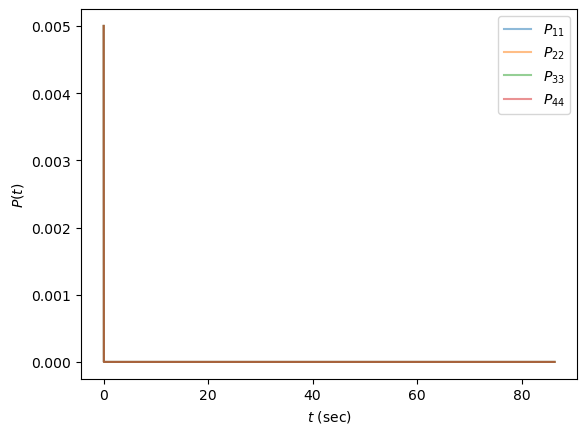

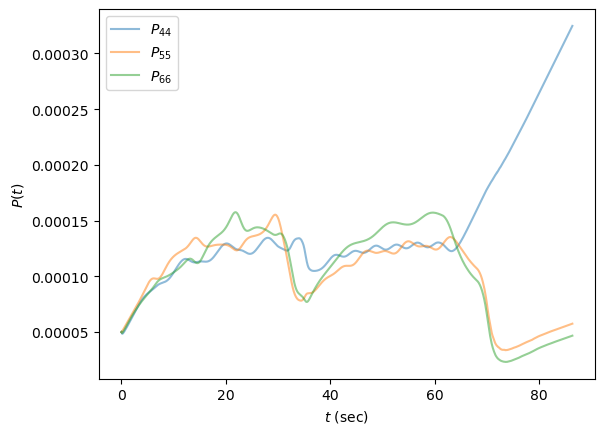

In [42]:
plt.plot(t_data[:], P_arr[:, 0, 0], alpha=0.5, label=r'$P_{11}$')
plt.plot(t_data[:], P_arr[:, 1, 1], alpha=0.5, label=r'$P_{22}$')
plt.plot(t_data[:], P_arr[:, 2, 2], alpha=0.5, label=r'$P_{33}$')
plt.plot(t_data[:], P_arr[:, 3, 3], alpha=0.5, label=r'$P_{44}$')
plt.legend()
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$P(t)$')
plt.show()

plt.plot(t_data[:], P_arr[:, 4, 4], alpha=0.5, label=r'$P_{44}$')
plt.plot(t_data[:], P_arr[:, 5, 5], alpha=0.5, label=r'$P_{55}$')
plt.plot(t_data[:], P_arr[:, 6, 6], alpha=0.5, label=r'$P_{66}$')
plt.legend()
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$P(t)$')
plt.show()

Already it is clear that this AEKF algorithm is not going well --- $|\beta| < 1$ for the entire state estimation run!
Why don't we instead force each prediction and posterior quaternion to be constrained to unit length? 

In [37]:
def filter_step_norm(
    x_prior: jnp.ndarray,
    P_prior: jnp.ndarray,
    w_obs: jnp.ndarray,
    b_obs: jnp.ndarray,
    R_w: jnp.ndarray,
    R_b: jnp.ndarray,
    Q: jnp.ndarray,
    H: jnp.ndarray,
    dt: float,
) -> Tuple[jnp.ndarray]:
    """ A single AEKF timestep that norms quaternion predictions and estimates.

    Args:
        x_prior (jnp.ndarray): 7x1 matrix, prior state vector estimate.
        P_prior (jnp.ndarray): 7x7 matrix, prior state covariance estimate.
        w_obs (jnp.ndarray): 3x1 matrix, observed attitude rate vector.
        b_obs (jnp.ndarray): 4x1 matrix, observed attitude, represented with
            quaternion b.
        R_w (jnp.ndarray): 3x3 matrix, attitude vector w covariance.
        R_b (jnp.ndarray): 4x4 matrix, quaternion measurement covariance.
        Q (jnp.ndarray): 7x7 matrix, process noise covariance for attitude
            rates and gyroscopic bias.
        H (jnp.ndarray): 4x7 matrix, measurement model matrix.
        dt (float): Integration time interval.

    Returns:
        Tuple[jnp.ndarray]: 6x1 matrix, 6x1 matrix, 6x6 matrix, updated
            state vector, noise vector, and process covariance estimates.
    """
    # Get linearized kinematics and noise matrices.
    F_prior = AEKF.tangent_f(x_prior, w_obs)
    # G_prior = AEKF.tangent_g(x_prior)

    # Get posterior predictions for state vector and state covariance
    # matrix.
    x_post = AEKF.pred_x(x_prior, w_obs, dt)
    x_post = x_post / jnp.linalg.norm(x_post)
    P_post = AEKF.pred_P_ricatti(P_prior, F_prior, Q, dt)

    # Get posterior error and Kalman gain.
    y = b_obs - H @ x_post
    K = AEKF.get_K(P_post, R_b, H)

    # Update state vector and state covariance estimate with Kalman gain.
    x_new = x_post + K @ y
    x_new = x_new / jnp.linalg.norm(x_new)
    P_new = (jnp.eye(7) - K @ H) @ P_post
    return x_new, P_new

# Update filter_step() to AEKF as as static method.
AEKF.filter_step_norm = staticmethod(filter_step_norm)


# Always reset!
# The bias should be around three degrees for all gyroscope axes.
bias = jnp.full((3, 1), 3. * jnp.pi / 180.)

# The initial quaternion values will be the mean of the first five observations.
b0 = jnp.mean(b_obs_data[:5], axis=0)
x = jnp.vstack([b0, bias])

# The initial state covariance will be the process covariance matrix multiplied
# by a constant > 1.
P = 5. * Q.copy()


@jit
def step_norm(
    x: jnp.ndarray,
    P: jnp.ndarray,
    w_obs: jnp.ndarray,
    b_obs: jnp.ndarray
) -> Tuple[jnp.ndarray]:
    """ AEKF filter step for given matrices R_w, R_b, and Q.
    """
    return AEKF.filter_step_norm(
        x, P, w_obs, b_obs,  # Variables.
        R_w, R_b, Q, AEKF.H, dt  # Constants.
    )


# Loop through and append new estimates.
x_list_norm = []
P_list_norm = []
for i in range(n_steps):
    x_list_norm.append(x)
    P_list_norm.append(P)
    x, P = step_norm(
        x, P,
        w_obs_data[i], b_obs_data[i],
    )

# Convert to arrays.
x_arr_norm = jnp.array(x_list_norm)
P_arr_norm = jnp.array(P_list_norm)


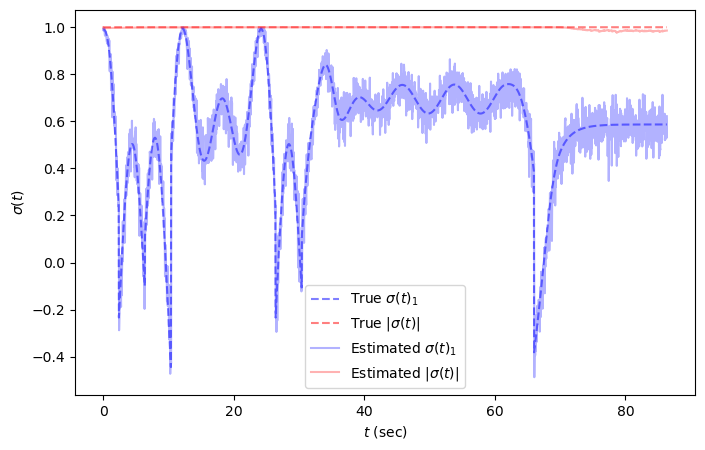

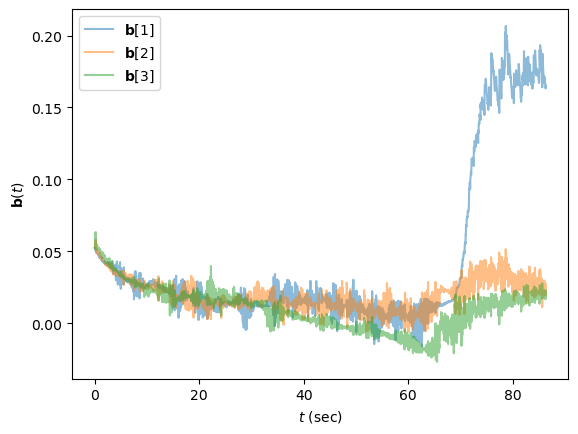

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(
    t_data[:], b_true_data[:, 0, 0], alpha=0.5, color='blue', ls='--',
    label=r'True $\sigma(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(b_true_data[:, :, 0], axis=1), alpha=0.5,
    color='red', label=r'True $|\sigma(t)|$', ls='--'
)
plt.plot(
    t_data[:], x_arr_norm[:, 0, 0], alpha=0.3, color='blue', ls='-',
    label=r'Estimated $\sigma(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(x_arr_norm[:, :4, 0], axis=1), alpha=0.3,
    color='red', label=r'Estimated $|\sigma(t)|$'
)
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\sigma(t)$')
plt.legend()
plt.show()

plt.plot(t_data[:], x_arr_norm[:, 4, 0], alpha=0.5, label=r'$\mathbf{b}[1]$')
plt.plot(t_data[:], x_arr_norm[:, 5, 0], alpha=0.5, label=r'$\mathbf{b}[2]$')
plt.plot(t_data[:], x_arr_norm[:, 6, 0], alpha=0.5, label=r'$\mathbf{b}[3]$')
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\mathbf{b}(t)$')
plt.legend()
plt.show()

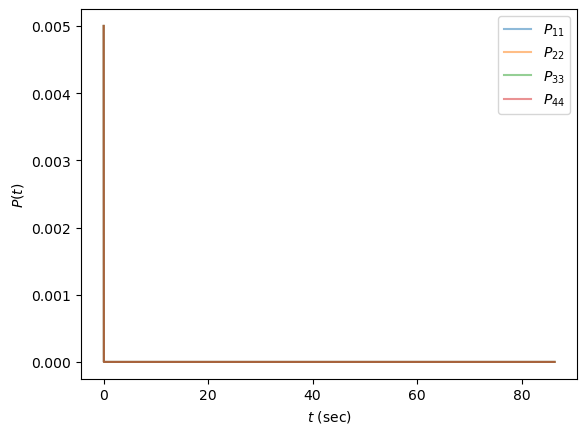

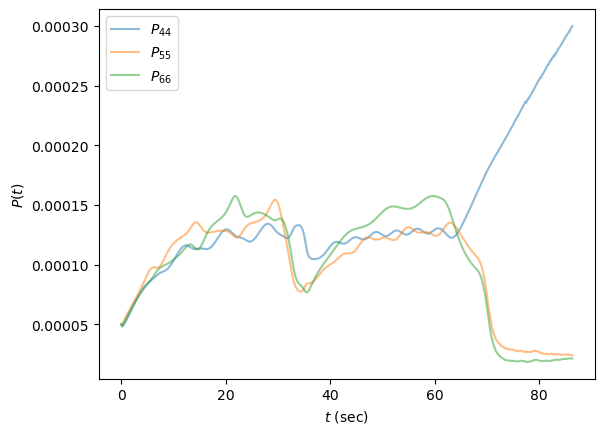

In [41]:
plt.plot(t_data[:], P_arr_norm[:, 0, 0], alpha=0.5, label=r'$P_{11}$')
plt.plot(t_data[:], P_arr_norm[:, 1, 1], alpha=0.5, label=r'$P_{22}$')
plt.plot(t_data[:], P_arr_norm[:, 2, 2], alpha=0.5, label=r'$P_{33}$')
plt.plot(t_data[:], P_arr_norm[:, 3, 3], alpha=0.5, label=r'$P_{44}$')
plt.legend()
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$P(t)$')
plt.show()

plt.plot(t_data[:], P_arr_norm[:, 4, 4], alpha=0.5, label=r'$P_{44}$')
plt.plot(t_data[:], P_arr_norm[:, 5, 5], alpha=0.5, label=r'$P_{55}$')
plt.plot(t_data[:], P_arr_norm[:, 6, 6], alpha=0.5, label=r'$P_{66}$')
plt.legend()
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$P(t)$')
plt.show()